In [1]:
import math
import numpy
from matplotlib import pyplot
%matplotlib inline

## Problem 1 ##

In [2]:
Uinf = 1.0                 # free-stream velocity
al = 2.0*math.pi/180       # angle of attack

In [3]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2            # collocation point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.n = [ math.cos(self.beta), math.sin(self.beta)]
        self.t = [-math.sin(self.beta), math.cos(self.beta)]
        
        self.kappa = 1                              # doublet strength
        self.vt = 0                                 # tangential velocity
        self.cp = 0                                 # pressure coefficient

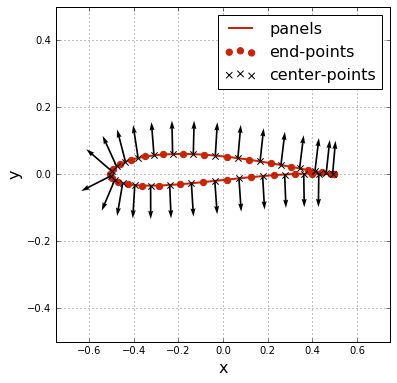

In [4]:
# plot NACA 2510 airfoil
N_panels = 30                    # number of panels desired

T = 0.1
H = 0.02
c = 1
a = c/4
r = (0.25+T/(3*math.sqrt(3)))                      # circle radius
zeta_c = -4*a/(3*math.sqrt(3))*T + 1j*2*a*H        # circle center
theta = numpy.linspace(0, 2*math.pi, N_panels+1)   # theta endpoints of panels
zeta = r*numpy.exp(1j*theta)                       # endpoints of circle surface panels
z_ends = (zeta+zeta_c) + a**2/(zeta+zeta_c)        # endpoints of airfoil surface panels
x_ends,  y_ends = z_ends.real, z_ends.imag
#x_ends = numpy.delete(x_ends,[1,N_panels-1])       # delete 2nd and 2nd to last points to merge panels
#y_ends = numpy.delete(y_ends,[1,N_panels-1])
N_panels = N_panels - 2

# define the panels
panels = numpy.empty(N_panels+1, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
panels[-1] = Panel(x_ends[0], y_ends[0], x_ends[0]+1000, y_ends[0])

# plot the panels
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', marker='x', s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels], [p.n[1] for p in panels],
              scale=10, width=0.005)
pyplot.legend(['panels', 'end-points', 'center-points'], loc='best', prop={'size':16})
pyplot.xlim(-0.75, 0.75)
pyplot.ylim(-0.5, 0.5);

In [5]:
def get_doublet_panel_velocity(p,x,y):
    """Evaluates the velocity components induced at coordinates (x,y) by a panel p.
    
    Arguments
    ---------
    p -- panel from which the velocity is induced
    x -- x-coordinate in global frame
    y -- y-coordinate in global frame
    
    Returns
    -------
    (u,v)-components of velocity at (x,y)
    """
    
    x_p =  math.sin(p.beta)*(x-p.xb) - math.cos(p.beta)*(y-p.yb)
    y_p =  math.cos(p.beta)*(x-p.xb) + math.sin(p.beta)*(y-p.yb)
    
    u_p = -p.kappa/(2*math.pi)*(y_p/(x_p**2+y_p**2) - y_p/((x_p-p.length)**2+y_p**2))
    v_p =  p.kappa/(2*math.pi)*(x_p/(x_p**2+y_p**2) - (x_p-p.length)/((x_p-p.length)**2+y_p**2))
    
    u =  math.sin(p.beta)*u_p + math.cos(p.beta)*v_p
    v = -math.cos(p.beta)*u_p + math.sin(p.beta)*v_p
    
    return u, v

In [6]:
# compute the influence coefficient matrix
A = numpy.zeros((N_panels+1, N_panels+1), dtype=float)

for i, p_i in enumerate(panels[0:N_panels]):
    for j, p_j in enumerate(panels):
        A[i,j] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
        if i == j:
            A[i,j] *= 1.001
A[-1,0] = -1
A[-1,-2] = 1
A[-1,-1] = -1

# compute the RHS of the linear system
b = numpy.zeros((N_panels+1, 1), dtype=float)
for i, p_i in enumerate(panels[0:N_panels]):
    b[i] = -numpy.dot(numpy.array([Uinf*math.cos(al), Uinf*math.sin(al)]), p_i.n)

In [7]:
# solves the linear system
kappa = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.kappa = float(kappa[i])

In [8]:
for i, p_i in enumerate(panels[0:N_panels]):
    vt = numpy.array([0])
    for j, p_j in enumerate(panels):
        if i != j:
            vt = vt + numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.t)
    if i == 0:
        R = math.sqrt((panels[1].xc-panels[0].xc)**2 + (panels[1].yc-panels[0].yc)**2)
        vt = vt - 0.5*(panels[1].kappa-panels[0].kappa)/R
    elif i == N_panels-1:
        R = math.sqrt((panels[N_panels-1].xc-panels[N_panels-2].xc)**2 + (panels[N_panels-1].yc-panels[N_panels-2].yc)**2)
        vt = vt - 0.5*(panels[N_panels-1].kappa-panels[N_panels-2].kappa)/R
    else:
        R = math.sqrt((panels[i+1].xc-panels[i-1].xc)**2 + (panels[i+1].yc-panels[i-1].yc)**2)
        vt = vt - 0.5*(panels[i+1].kappa-panels[i-1].kappa)/R
    vt = vt + numpy.dot(numpy.array([Uinf*math.cos(al), Uinf*math.sin(al)]), p_i.t)
    p_i.vt = float(vt)
    p_i.cp = 1.0 - (p_i.vt/Uinf)**2
    

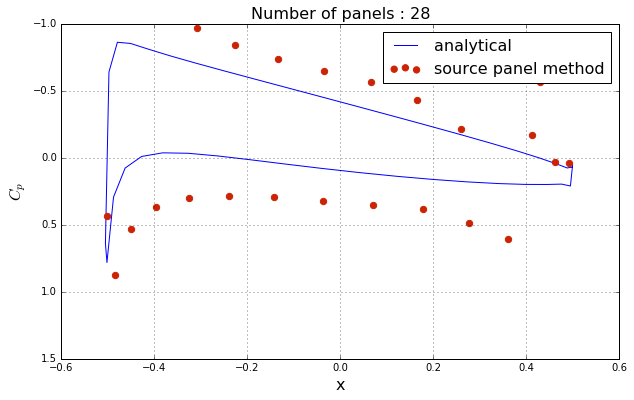

In [9]:
# create surface of airfoil for analytical solution
theta = numpy.linspace(0.01, 2*math.pi-0.01, 41)      # theta coordinates
zeta = r*numpy.exp(1j*theta)                          # circle coordinates
z = (zeta+zeta_c) + a**2/(zeta+zeta_c)                # airfoil coordinates

# flow parameters
kappa = 2*math.pi*Uinf*r**2                   # doublet strength for circle with radius r
Gam = 4*math.pi*r*Uinf*numpy.sin(al+2*H)      # vortex strength

# compute the complex velocity on the surface
w = Uinf - kappa/(2*math.pi)/zeta**2 + 1j*Gam/(2*math.pi)/zeta
zeta = zeta*numpy.exp(1j*al)

# Joukowski transformation
w = w/(1 - a**2/(zeta+zeta_c)**2)
cp_analytical = 1 - numpy.abs(w)**2/Uinf**2

# plots the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(z.real, cp_analytical, color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels[0:N_panels]], [p.cp for p in panels[0:N_panels]], color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(['analytical', 'source panel method'], loc='best', prop={'size':16})
pyplot.xlim(-0.6, 0.6)
pyplot.ylim(-1, 1.5)
pyplot.gca().invert_yaxis();